In [44]:
import pandas as pd
import numpy as np
import pymysql
import copy
from hmmlearn.hmm import CategoricalHMM

# cursor.fetchall() - list of tuples return
# list에서 원소들의 중복은 허용되지 않음.
# mysql 에서 list 타입은 없음

In [45]:
# time_period 수
TIME_PERIOD = 4

# cluster 수 : Hidden State수
N_COMPONENTS = 20

# 방출확률 수
N_FEATURES = N_COMPONENTS * TIME_PERIOD

### 사용자 데이터 받아서 경로 처리

In [46]:
def label_sequence(path, time_period):
    l_sequence = []
    for idx in range(0, len(path)):
        LID = int(path[idx].replace('POI', ''))
        T = 0
        
        if time_period[idx] == '새벽':
            T = 0
        elif time_period[idx] == '오전':
            T = 1
        if time_period[idx] == '오후':
            T = 2
        elif time_period[idx] == '저녁':
            T = 3
            
        l_sequence.append( LID * 4 + T )
    return l_sequence

In [47]:
import ast
def df_str_to_list(df):
    try:
        columns = ['trajectory_id', 'path', 'time_period']
        for column in columns:
            df[column] = df[column].apply(ast.literal_eval)
        return df
    except (ValueError, SyntaxError):
        print("Invalid input string format. Please provide a valid list-like string.")
        

In [48]:
#****************** initial probability **********************#
def calculate_initial_probability(X):
    start_proba = np.zeros(N_COMPONENTS)

    # start_point
    for value in X[:, 0]:
        start_proba[int(value.replace("POI", ""))] += 1

    total = np.sum(start_proba)

    if total != 0:
        start_proba /= total

    return start_proba


In [49]:
# #****************** transition probability **********************#
# # transition_matrix : transition 횟수 count 저장, transition_probability : transition 확률 저장
def calculate_transition_probability(X):
        
    transition_proba = np.zeros((N_COMPONENTS, N_COMPONENTS))

    # transition 횟수 count
    # X[:, 2] : 'path'
    for trajectory in X[:, 2]:

        for i in range(len(trajectory) - 1):
            cur_POI_num = int(trajectory[i].replace('POI',''))
            next_POI_num = int(trajectory[i+1].replace('POI',''))
            
            transition_proba[cur_POI_num, next_POI_num] += 1
            

    for i in range(len(transition_proba)):
        total = np.sum(transition_proba[i])
        if total != 0:
            transition_proba[i] /= total
    return transition_proba


In [50]:
#****************** emission probability **********************#
# 각 POI일떄 Labelsequence가 나올확률
def calculate_emission_probability(X):
        # emission Probability 구하기
    emission_proba = np.zeros(shape=(N_COMPONENTS, N_FEATURES))
 
    # X[:, [2,4]] : ['path','l_sequence']
    for p, l_seq in X[:, [2,4]]:
        for cur_POI_num, cur_l_seq in zip(p, l_seq):
            cur_POI_num = int(cur_POI_num.replace('POI',''))
            emission_proba[cur_POI_num][cur_l_seq] +=1
        

    for i in range(len(emission_proba)):
        total = np.sum(emission_proba[i])
        
        if total != 0:
            emission_proba[i] /= total

    return emission_proba


### mySQL에 데이터 불러오기

In [51]:
# cmd에서 mysql -u root -p 로 root 사용자 접속
# mySQL workbench에서 root 계정으로 접속 후 TRAJECTORY db 생성

db_name = "spring_db"
table_name = "spring_table"

In [52]:
conn = pymysql.connect(host='localhost', user='root', password='0000', db=db_name)
cur = conn.cursor(pymysql.cursors.DictCursor)

In [53]:
query = f"SELECT * FROM {table_name}"
cur.execute(query)

spring_df = pd.DataFrame(cur.fetchall())
spring_df = df_str_to_list(spring_df)
spring_df

,trajectory_id,start_point,end_point,path,time_period
0,"(2020, 3, 14, 46100055)",POI7,POI4,"[POI7, POI13, POI19, POI13, POI19, POI6, POI0,...","[오전, 오전, 오전, 오전, 오전, 오전, 오전, 오전, 오전, 오후, 오후, 오..."
1,"(2020, 3, 14, 46100056)",POI0,POI6,"[POI0, POI6, POI0, POI12, POI2, POI16, POI2, P...","[오전, 오전, 오전, 오전, 오전, 오후, 오후, 오후, 오후, 오후, 오후, 오..."
2,"(2020, 3, 14, 4610007e)",POI2,POI16,"[POI2, POI10, POI2, POI16]","[오전, 오후, 오후, 오후]"
3,"(2020, 3, 14, 461000b6)",POI18,POI8,"[POI18, POI3, POI17, POI3, POI18, POI8]","[오전, 오전, 오전, 오후, 오후, 오후]"
4,"(2020, 3, 14, 461000b7)",POI16,POI4,"[POI16, POI2, POI10, POI2, POI16, POI4]","[오후, 오후, 오후, 저녁, 저녁, 저녁]"
...,...,...,...,...,...
29967,"(2021, 5, 9, 461004ed)",POI12,POI5,"[POI12, POI5]","[새벽, 새벽]"
29968,"(2021, 5, 9, 4610114c)",POI13,POI8,"[POI13, POI7, POI8]","[새벽, 새벽, 새벽]"
29969,"(2021, 5, 9, 461017a6)",POI5,POI3,"[POI5, POI0, POI3]","[새벽, 새벽, 새벽]"
29970,"(2021, 5, 9, 461017a7)",POI14,POI2,"[POI14, POI2]","[새벽, 새벽]"


In [54]:
spring_df['l_sequence'] = [np.array(label_sequence(path, time_period)) for path, time_period in spring_df[['path', 'time_period']].values]
spring_df

,trajectory_id,start_point,end_point,path,time_period,l_sequence
0,"(2020, 3, 14, 46100055)",POI7,POI4,"[POI7, POI13, POI19, POI13, POI19, POI6, POI0,...","[오전, 오전, 오전, 오전, 오전, 오전, 오전, 오전, 오전, 오후, 오후, 오...","[29, 53, 77, 53, 77, 25, 1, 21, 61, 42, 10, 66..."
1,"(2020, 3, 14, 46100056)",POI0,POI6,"[POI0, POI6, POI0, POI12, POI2, POI16, POI2, P...","[오전, 오전, 오전, 오전, 오전, 오후, 오후, 오후, 오후, 오후, 오후, 오...","[1, 25, 1, 49, 9, 66, 10, 42, 10, 50, 2, 26, 7..."
2,"(2020, 3, 14, 4610007e)",POI2,POI16,"[POI2, POI10, POI2, POI16]","[오전, 오후, 오후, 오후]","[9, 42, 10, 66]"
3,"(2020, 3, 14, 461000b6)",POI18,POI8,"[POI18, POI3, POI17, POI3, POI18, POI8]","[오전, 오전, 오전, 오후, 오후, 오후]","[73, 13, 69, 14, 74, 34]"
4,"(2020, 3, 14, 461000b7)",POI16,POI4,"[POI16, POI2, POI10, POI2, POI16, POI4]","[오후, 오후, 오후, 저녁, 저녁, 저녁]","[66, 10, 42, 11, 67, 19]"
...,...,...,...,...,...,...
29967,"(2021, 5, 9, 461004ed)",POI12,POI5,"[POI12, POI5]","[새벽, 새벽]","[48, 20]"
29968,"(2021, 5, 9, 4610114c)",POI13,POI8,"[POI13, POI7, POI8]","[새벽, 새벽, 새벽]","[52, 28, 32]"
29969,"(2021, 5, 9, 461017a6)",POI5,POI3,"[POI5, POI0, POI3]","[새벽, 새벽, 새벽]","[20, 0, 12]"
29970,"(2021, 5, 9, 461017a7)",POI14,POI2,"[POI14, POI2]","[새벽, 새벽]","[56, 8]"


In [55]:
from sklearn.model_selection import train_test_split
select_columns = ['start_point','end_point','path','time_period','l_sequence' ]
X = np.array(spring_df[select_columns])

# X = np.array(spring_df[['l_sequence']])

X_train, X_test = train_test_split(X, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(20980, 5)
(8992, 5)


In [56]:
hmm_model = CategoricalHMM(n_components=20, n_features=80)

hmm_model.startprob_ = calculate_initial_probability(X_train)
hmm_model.transmat_ = calculate_transition_probability(X_train)
hmm_model.emissionprob_ = calculate_emission_probability(X_train)

In [57]:
# 'l_sequence' 모두 선택
X_train = X_train[:, 4]
X_test = X_test[:, 4]


In [58]:
def sequence_accuracy(true_sequences, predicted_sequences):
    correct_sequences = np.sum([np.array_equal(true_seq, pred_seq) for true_seq, pred_seq in zip(true_sequences, predicted_sequences)])
    total_sequences = len(true_sequences)
    accuracy = correct_sequences / total_sequences
    return accuracy

### MySQL 전체 데이터(3,4,5월)로 테스트

In [59]:
predicted_sequences = [hmm_model.predict(np.atleast_2d(seq)) for seq in X_test]
predicted_sequences[0:5]

[array([14, 18,  2, 14,  2, 18], dtype=int64),
 array([15, 18,  2, 18, 15,  6, 15,  6], dtype=int64),
 array([19,  9,  1, 14,  1, 14,  7, 19,  6,  7, 14,  1,  9], dtype=int64),
 array([ 7, 11, 14,  2, 11, 10, 14], dtype=int64),
 array([17,  9, 18,  9, 16, 17, 16,  3,  9, 17, 16,  3,  0,  5, 12],
       dtype=int64)]

In [60]:
# X_test의 l_sequence에서 POI sequence 추출
true_sequences = [seq // 4 for seq in X_test]
true_sequences[0:5]

[array([14, 18,  2, 14,  2, 18], dtype=int32),
 array([15, 18,  2, 18, 15,  6, 15,  6], dtype=int32),
 array([19,  9,  1, 14,  1, 14,  7, 19,  6,  7, 14,  1,  9], dtype=int32),
 array([ 7, 11, 14,  2, 11, 10, 14], dtype=int32),
 array([17,  9, 18,  9, 16, 17, 16,  3,  9, 17, 16,  3,  0,  5, 12],
       dtype=int32)]

In [61]:
acc = sequence_accuracy(true_sequences, predicted_sequences)
acc

1.0

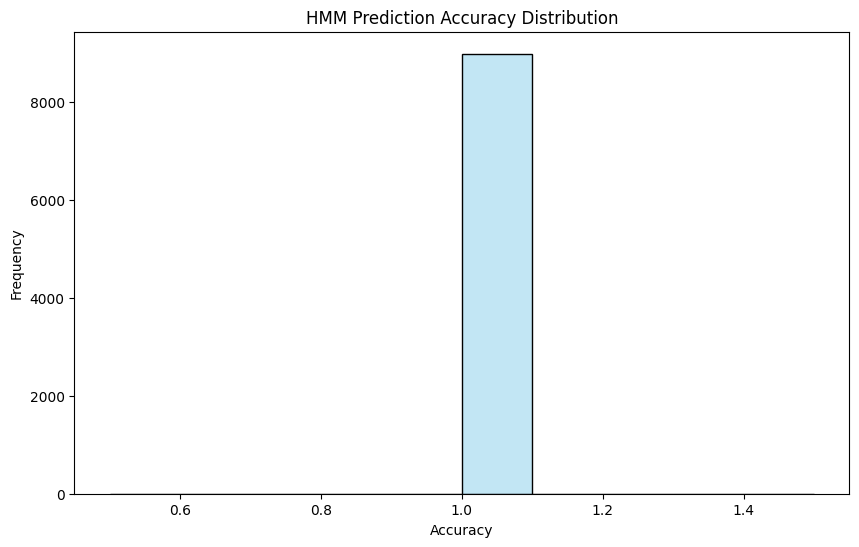

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate accuracy for each test sample
accuracy = [np.mean(pred == true) for pred, true in zip(predicted_sequences, true_sequences)]

plt.figure(figsize=(10, 6))
sns.histplot(accuracy, bins=10, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('HMM Prediction Accuracy Distribution')
plt.show()


### Next POI를 붙여가며 max score를 가지는 POI 찾기

In [63]:
# 다음 지점 예측
def predict_next_POI(model, user_sequence):
    next_symbol = 0
    max_prob = -100
    for symbol in range(0, 200):
        can_sequence = copy.deepcopy(user_sequence)
        can_sequence.append(symbol)
        print(can_sequence)
        temp = model.score(np.array(can_sequence).reshape(-1, 1))
        
        # 한 후보지의 발생 확률이 이전 값보다 클 경우 next_symbol update
        if temp > max_prob:
            print("prob updated from ", max_prob, " to ", temp)
            max_prob = temp
            print("symbol updated from ", next_symbol, " to ", symbol)
            next_symbol = symbol
    modified_symbol = next_symbol - 7
    next_POI = (modified_symbol - modified_symbol%4)/(2*2) + 1
    return next_POI

In [64]:
# X_test에 대해 Next_State 확률이 가장 큰 POI를 추출하고
# 실제 경로와 일치하는지 확인
count = 0
for i in range(len(X_test)):

    user_sequence_select = X_test[i]

    user_sequence = user_sequence_select[:-1]
    last_label_sequence = user_sequence_select[-1]

    last_label_sequence_to_POI = last_label_sequence // 4

    can_sequences = [ np.array(list(user_sequence) + [i]) for i in range(80)]

    score_list = np.array([hmm_model.score(can_sequence.reshape(-1, 1)) for can_sequence in can_sequences])

    max_score_idx = score_list.argmax()
    next_POI_num = max_score_idx // 4

    # print("경로에서 추출한 마지막 POI :", last_label_sequence_to_POI)
    # print("Max Score를 가지는 POI : ",next_POI_num)
    # print("----------------------------------------")
    if last_label_sequence_to_POI == next_POI_num:
        count += 1

print("Number of Total Data :", len(X_test))
print("Number of Correct Data : ",count)


Number of Total Data : 8992
Number of Correct Data :  3637


In [65]:
print("accuracy :", count / len(X_test))

accuracy : 0.404470640569395


Last Data From Sequence : 18
Max Score POI :  14


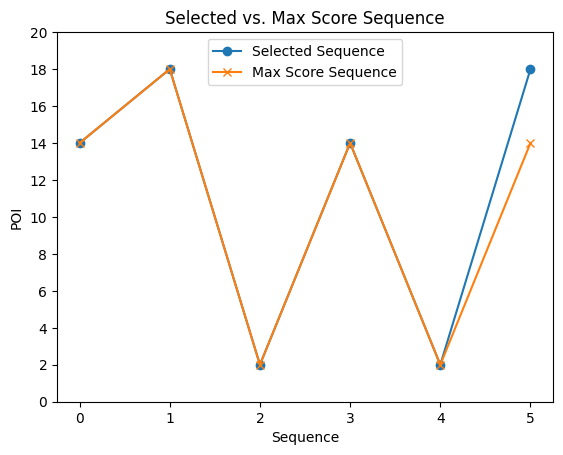


Last Data From Sequence : 6
Max Score POI :  18


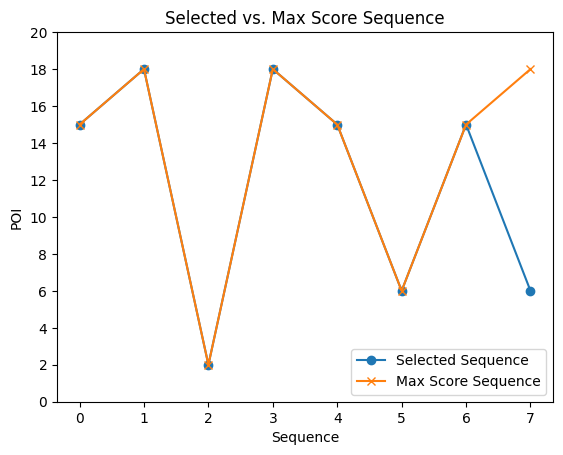


Last Data From Sequence : 9
Max Score POI :  13


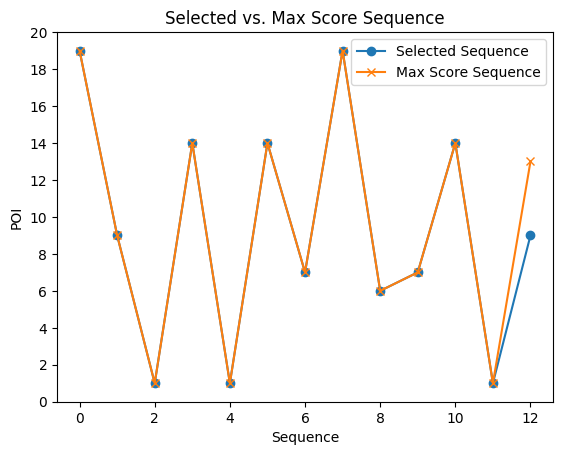


Last Data From Sequence : 14
Max Score POI :  14


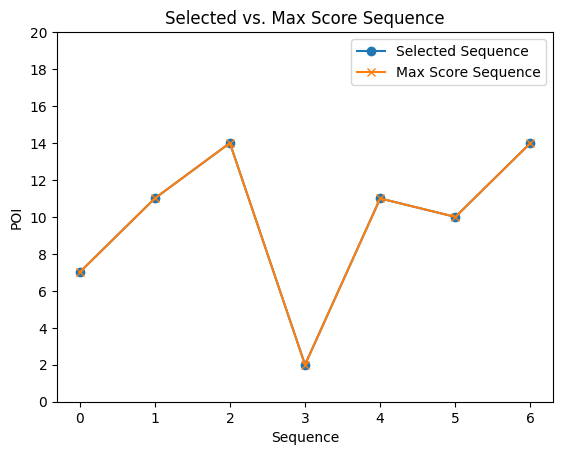


Last Data From Sequence : 12
Max Score POI :  12


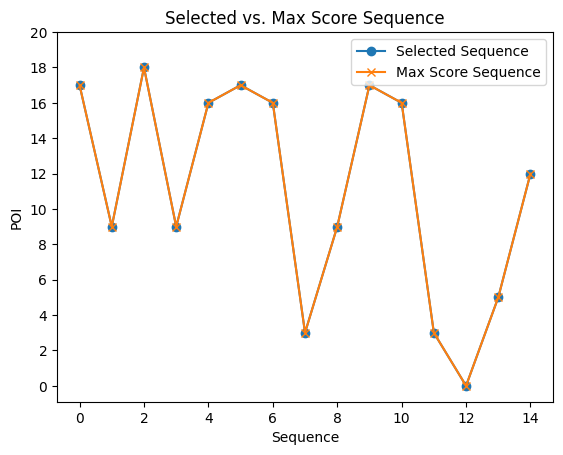


Last Data From Sequence : 17
Max Score POI :  19


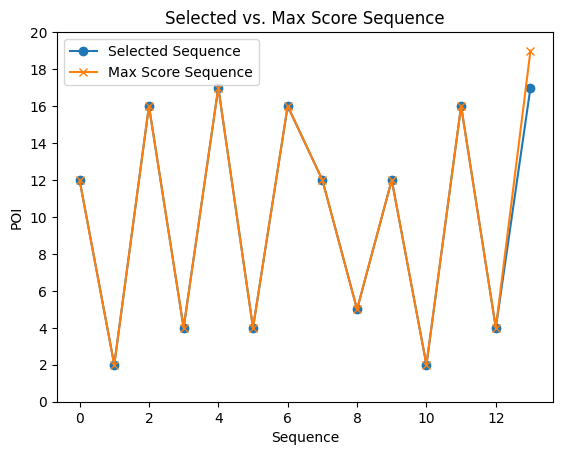


Last Data From Sequence : 10
Max Score POI :  12


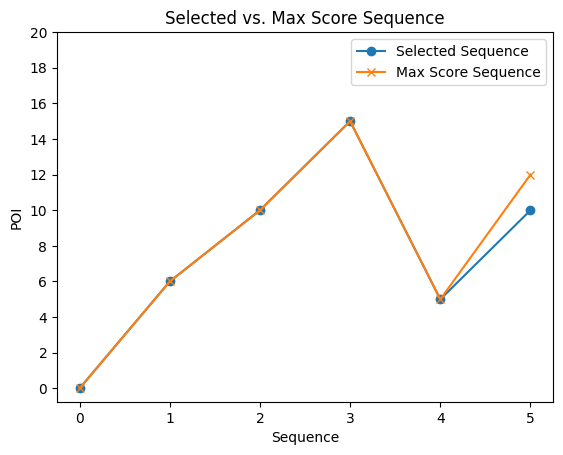


Last Data From Sequence : 15
Max Score POI :  2


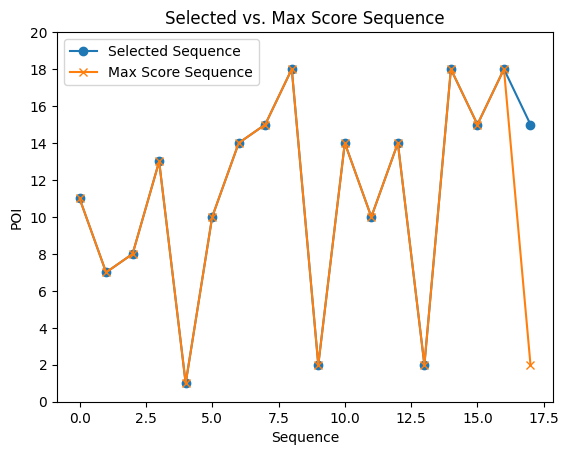


Last Data From Sequence : 10
Max Score POI :  10


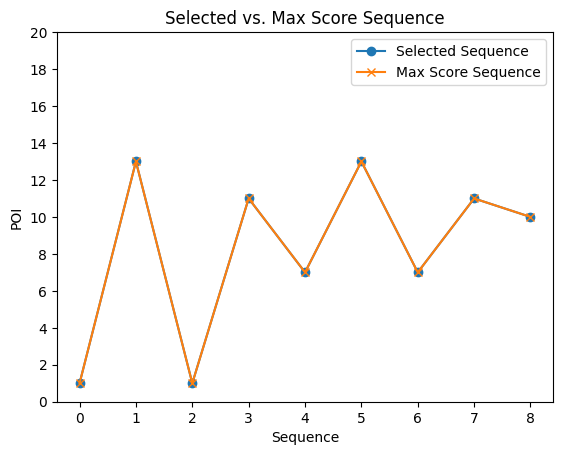


Last Data From Sequence : 7
Max Score POI :  10


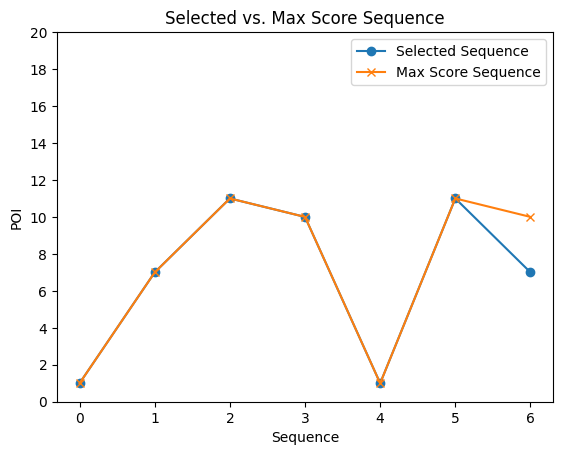

In [95]:
# 데이터 10개만 확인
for i in range(10):
    # seed = np.random.randint(0,len(X_test))
    # user_sequence_select = X_test[seed]

    user_sequence_select = X_test[i]
    # last point를 뺀 sequence
    user_sequence = user_sequence_select[:-1]

    # last sequence, last sequence의 POI 번호
    last_label_sequence = user_sequence_select[-1]
    last_label_sequence_POI_num = last_label_sequence // 4

    can_sequences = [np.array(list(user_sequence) + [i]) for i in range(80)]

    # can_sequence의 로그우도함수 list
    score_list = np.array([hmm_model.score(can_sequence.reshape(-1, 1)) for can_sequence in can_sequences])

    # can_sequence의 score의 최대값을 가지는 index 추출
    max_score_idx = score_list.argmax()
    next_POI_num = max_score_idx // 4

    print("Last Data From Sequence :", last_label_sequence_POI_num)
    print("Max Score POI : ", next_POI_num)

    plt.plot(user_sequence_select//4, label='Selected Sequence', marker='o')

    # Plot predicted_sequence
    plt.plot(np.append(user_sequence, max_score_idx)//4, label='Max Score Sequence', marker='x')

    plt.xlabel('Sequence')
    plt.ylabel('POI')
    plt.yticks(np.arange(0, 21, 2))
    plt.title('Selected vs. Max Score Sequence')
    plt.legend()
    plt.show()
    print()


### 3월 데이터를 Train Set으로 4월 데이터를 Test Set으로 테스트

In [67]:
month_3_df = spring_df[spring_df['trajectory_id'].apply(lambda x : x[1] == 3)]
month_4_df = spring_df[spring_df['trajectory_id'].apply(lambda x : x[1] == 4)]


In [68]:
hmm_model_month_3 = CategoricalHMM(n_components=20, n_features=80)

hmm_model_month_3.startprob_ = calculate_initial_probability(month_3_df[select_columns].values)
hmm_model_month_3.transmat_ = calculate_transition_probability(month_3_df[select_columns].values)
hmm_model_month_3.emissionprob_ = calculate_emission_probability(month_3_df[select_columns].values)



In [69]:
month_4_l_seq = month_4_df['l_sequence'].values

In [70]:
predicted_sequences_month_4 = [hmm_model_month_3.predict(np.atleast_2d(seq)) for seq in month_4_l_seq]
predicted_sequences_month_4[0:5]

[array([14,  2, 14, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,  0],
       dtype=int64),
 array([10,  1, 13,  8], dtype=int64),
 array([ 5,  0,  3,  0,  5, 12, 19,  4, 13,  7, 11, 10, 14,  2, 14],
       dtype=int64),
 array([ 2, 18,  5, 12, 19,  4, 13,  8, 13,  4, 19, 12,  5,  0,  3],
       dtype=int64),
 array([10,  1, 19,  0], dtype=int64)]

In [71]:
# X_test의 l_sequence에서 POI sequence 추출
true_sequences_month_4 = [seq // 4 for seq in month_4_l_seq]
true_sequences[0:5]

[array([14, 18,  2, 14,  2, 18], dtype=int32),
 array([15, 18,  2, 18, 15,  6, 15,  6], dtype=int32),
 array([19,  9,  1, 14,  1, 14,  7, 19,  6,  7, 14,  1,  9], dtype=int32),
 array([ 7, 11, 14,  2, 11, 10, 14], dtype=int32),
 array([17,  9, 18,  9, 16, 17, 16,  3,  9, 17, 16,  3,  0,  5, 12],
       dtype=int32)]

In [72]:
acc = sequence_accuracy(true_sequences_month_4, predicted_sequences_month_4)
acc

0.5250414917504638

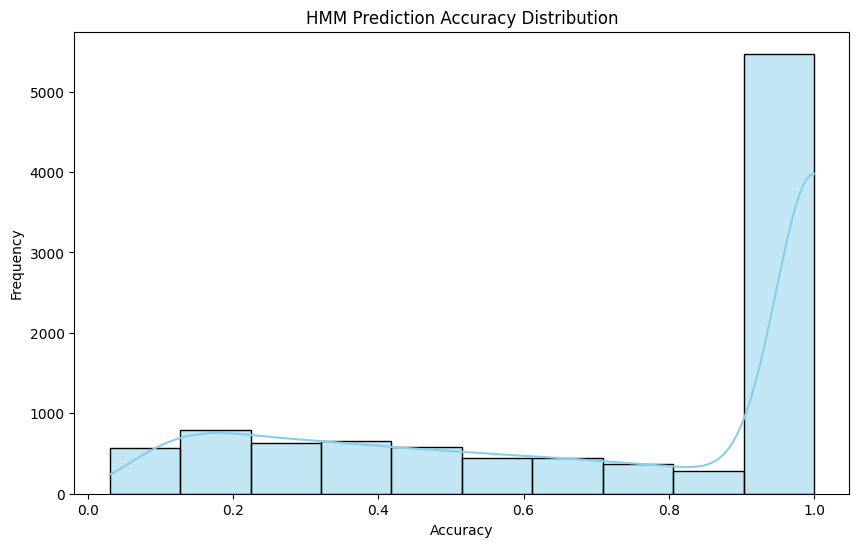

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = [np.mean(true == pred) for true, pred in zip(true_sequences_month_4, predicted_sequences_month_4)]


plt.figure(figsize=(10, 6))
sns.histplot(accuracy, bins=10, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('HMM Prediction Accuracy Distribution')
plt.show()

